In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 使用 3d 图必须要先 import Axes3D

%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [31]:
def vis_loss_weight_map(curve_data_path, step=1):
    curves_data = np.load(curve_data_path).squeeze()  # (100, 2, 100)

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.set_xlabel('loss')
    # ax.set_ylabel('epoch')
    ax.set_yticks([])
    ax.set_zlabel('weight')
#     ax.set_zlim(0.4,1)
    # ax.set_title('mw_cifar10_imb100')
    ax.view_init(0, -90)  # vertical,horizontal

    for i in range(len(curves_data)):
        if i % step == 0:
            x = curves_data[i][0]
            z = curves_data[i][1]
            y = np.array([i] * len(x))
            ax.plot3D(x, y, z)
            ax.text(x[99], y[99], z[99], f'{i}', 
                    color='gray', 
                    fontdict={
#                         'fontweight': 'bold',
                        'size': 9
                    })

## VNet, meta_update_step = 10

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


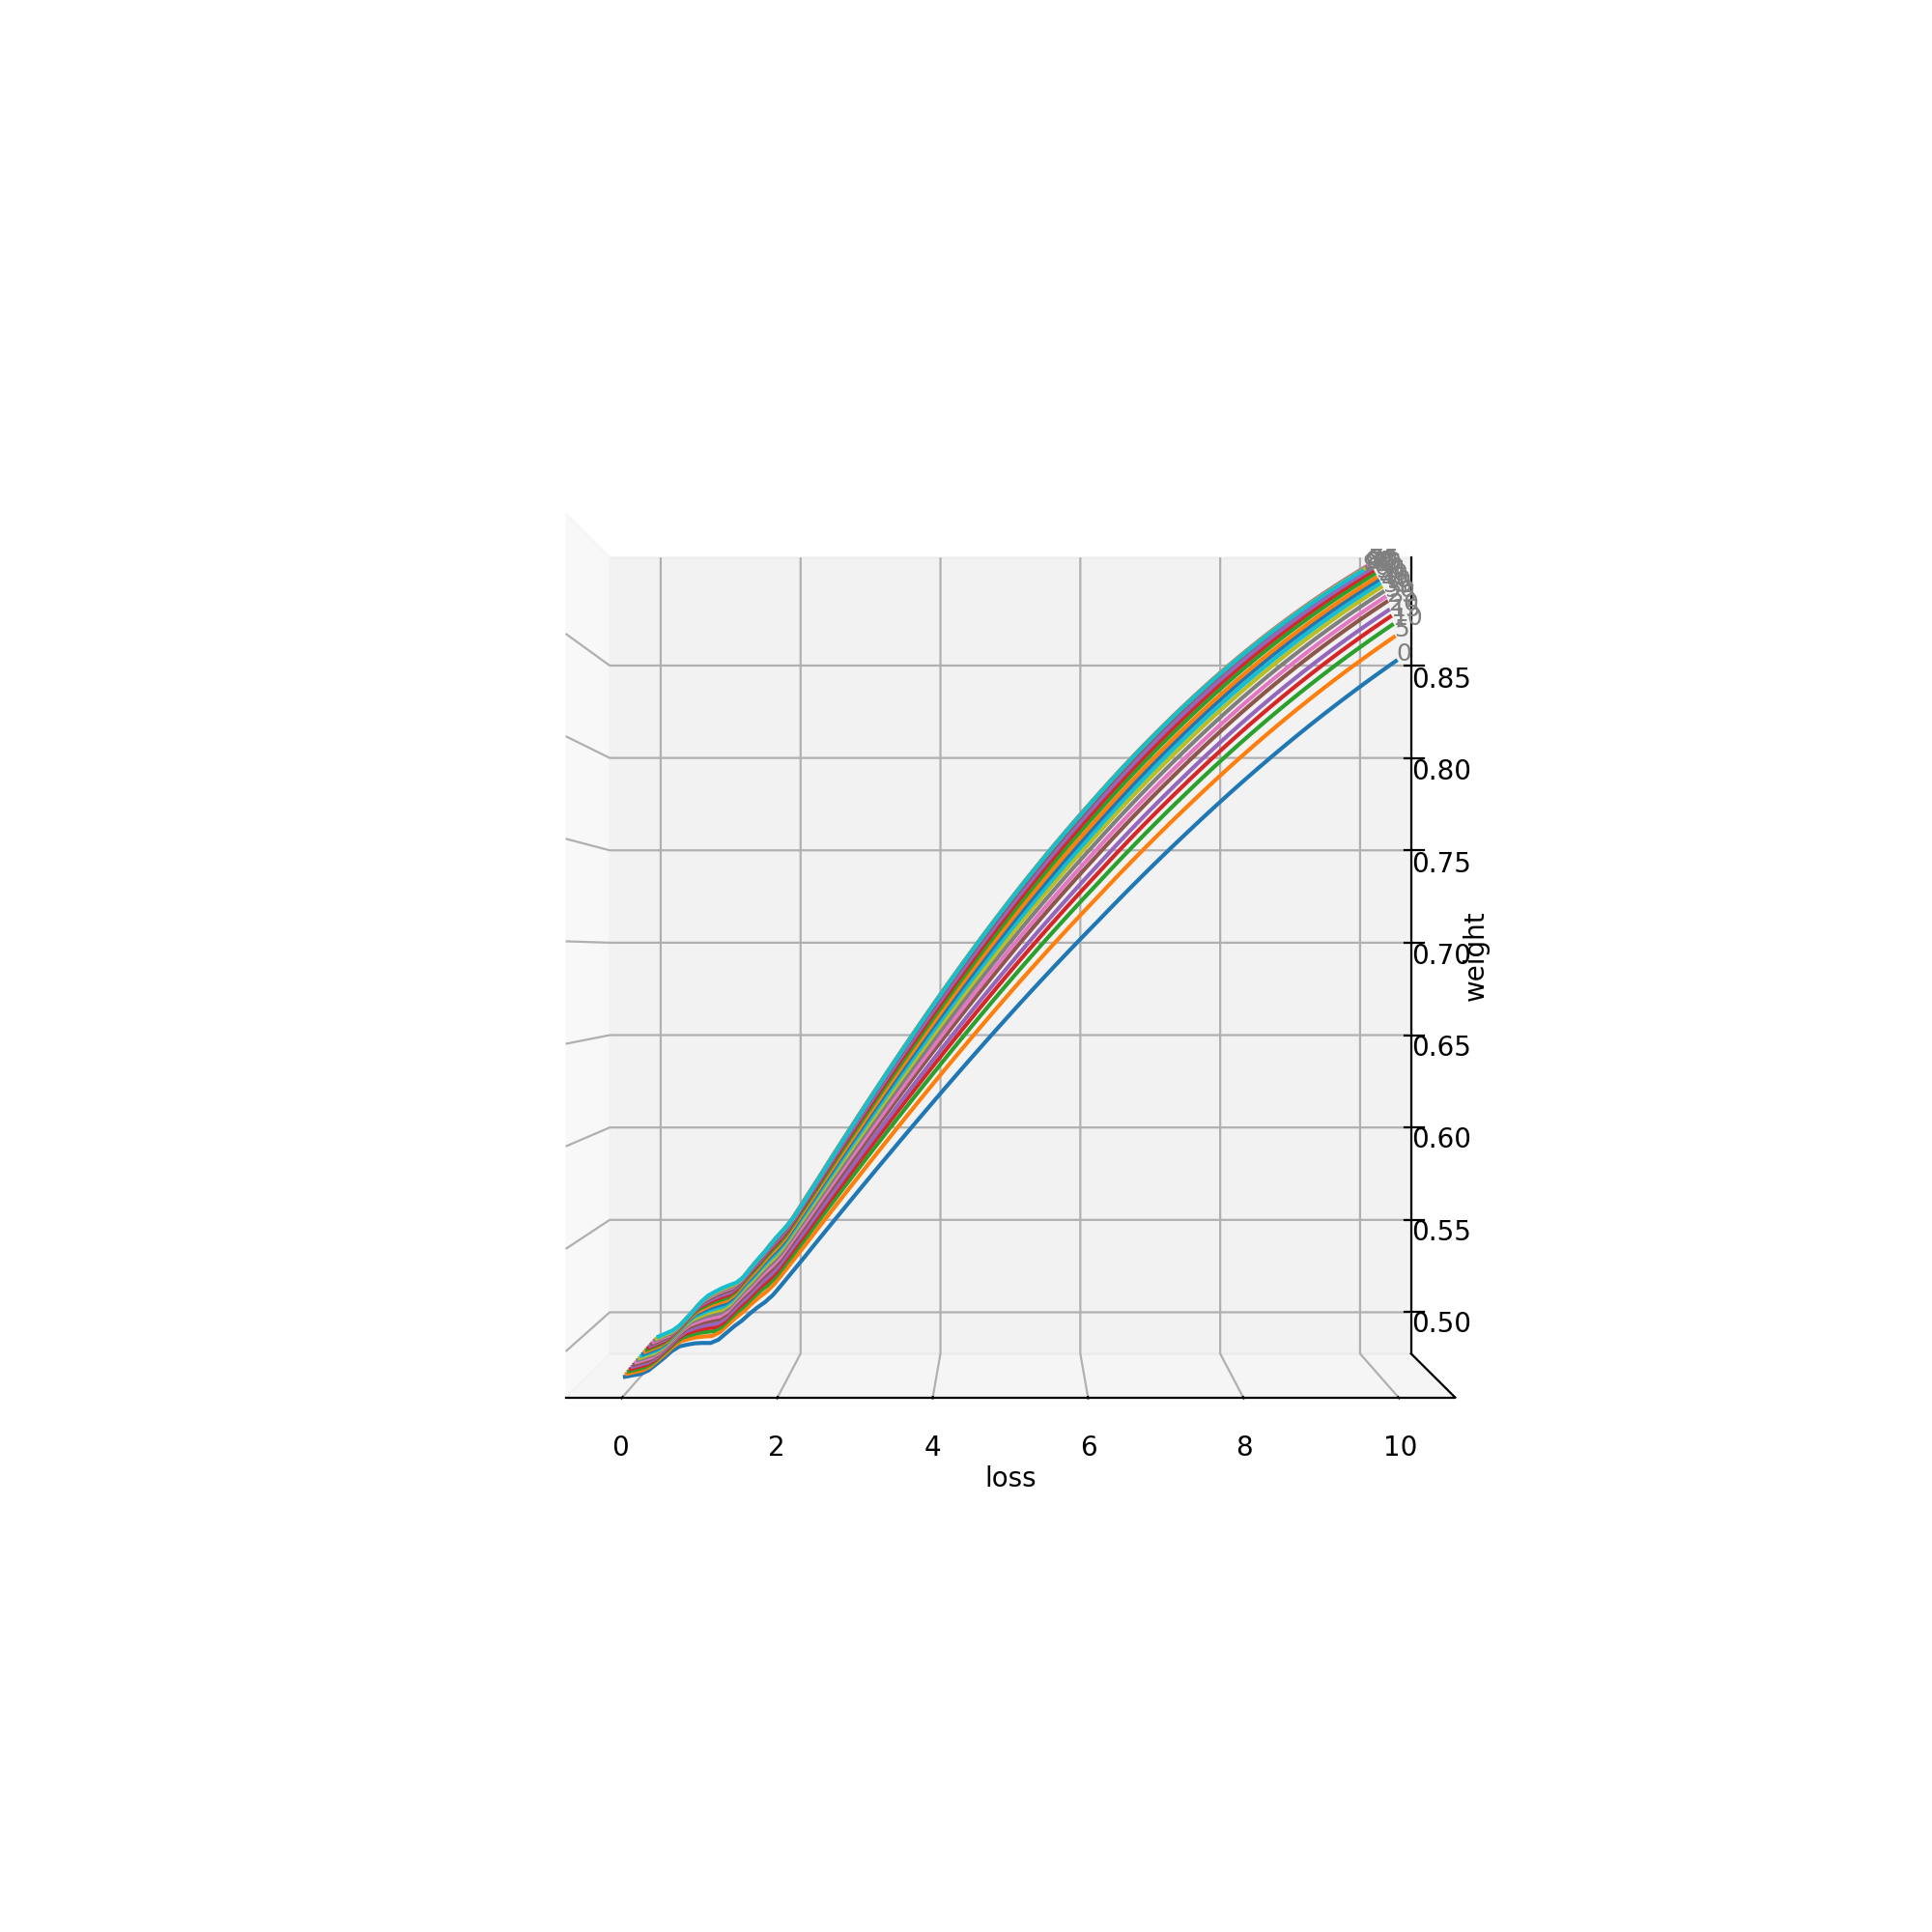

In [33]:
%matplotlib auto
%matplotlib notebook

# vis_loss_weight_map('npy/mw_cifar10_imb50_Mar11_152902_curves_data.npy', step=5)
vis_loss_weight_map('npy/mw_cifar10_imb50_Mar11_203458_curves_data.npy', step=5)
# vis_loss_weight_map('npy/mw_cifar100_imb50_Mar12_110726_curves_data.npy', step=5)

## VNet v2, meta_update_step = 10

<IPython.core.display.Javascript object>


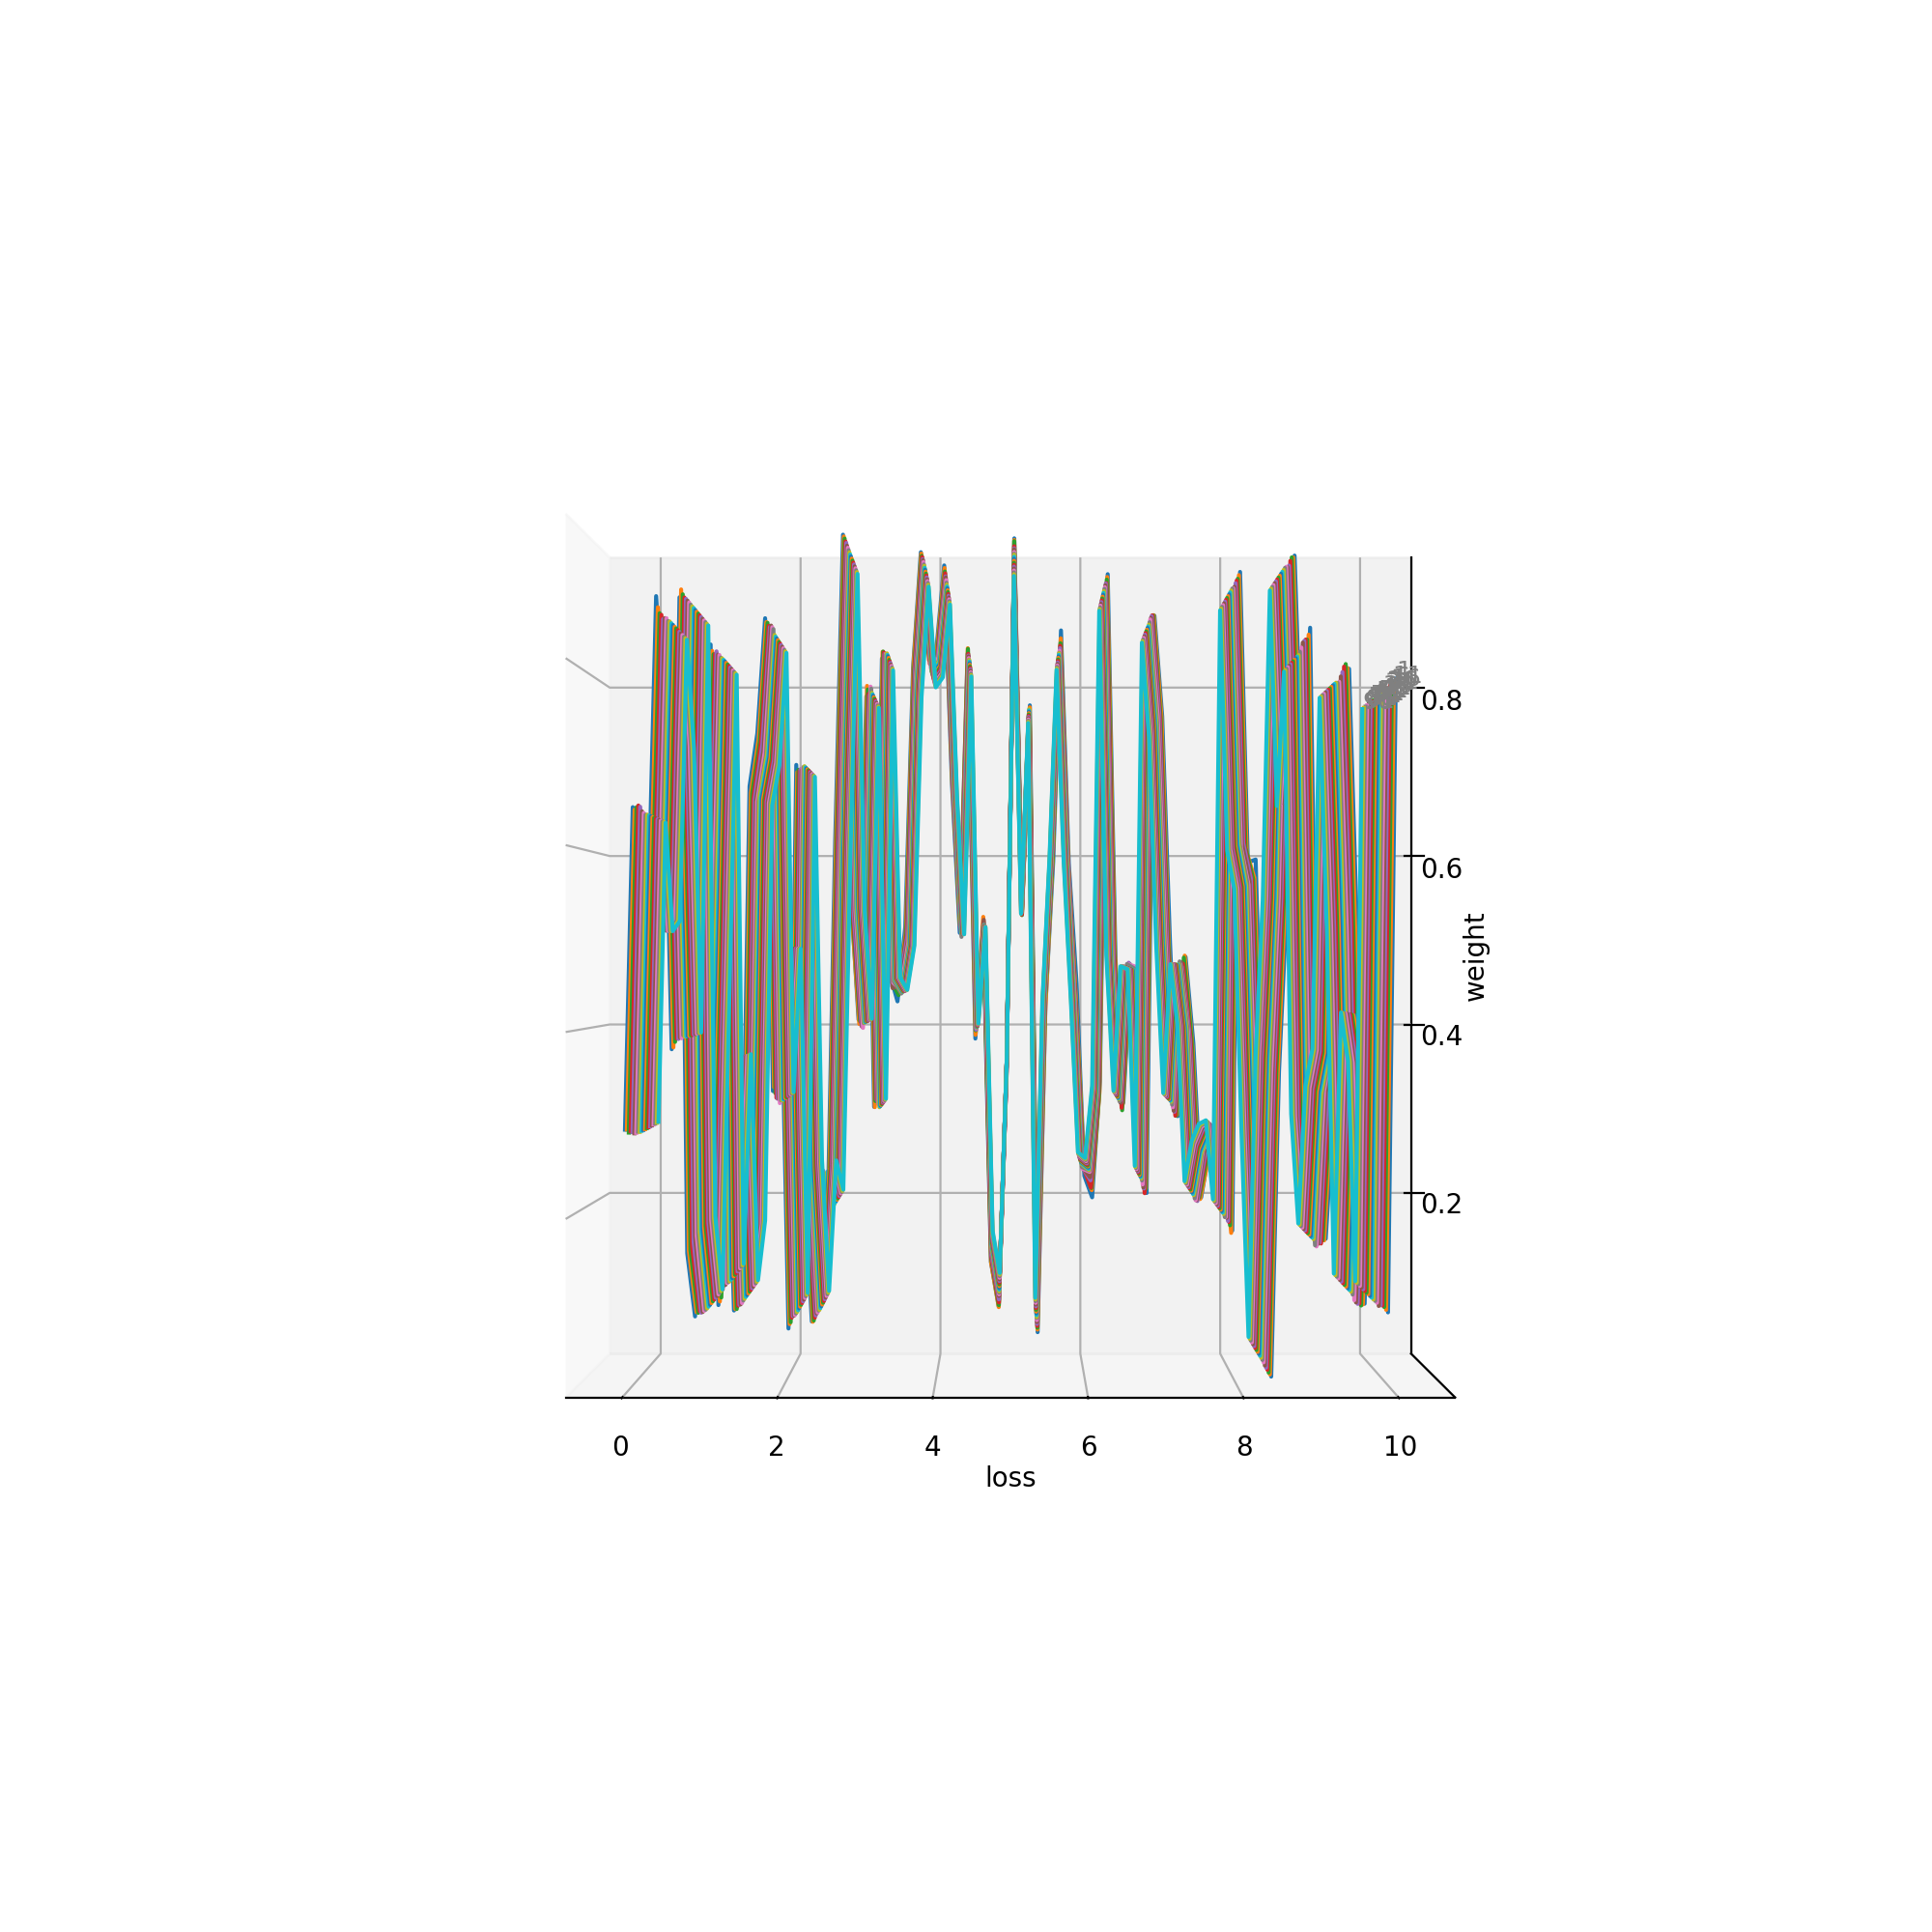

In [8]:
vis_loss_weight_map('npy/mw_v2_cifar10_imb50_Mar11_152932_curves_data.npy', step=5)  # batch vnet

## sample loss-weight scatter

### build dataloader

- 因为 `valid_loader` 也用了和 `imbalanced_train_loader` 同样的 transform，导致如果在 meta data 上测试，会出现每次 acc 不同

In [2]:
from dataset.data_utils import get_imb_meta_test_datasets
from torch.utils.data import DataLoader
import random

random.seed(42)
imb_train_dataset, meta_train_dataset, test_dataset = get_imb_meta_test_datasets(
    dataset='cifar10', num_classes=10, num_meta=10, imb_factor=50
)

imbalanced_train_loader = DataLoader(imb_train_dataset, batch_size=100, drop_last=True, shuffle=True)
valid_loader = DataLoader(meta_train_dataset, batch_size=100, drop_last=True, shuffle=False) # 比 batch_loss 对比
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

print(len(imbalanced_train_loader))
print(len(valid_loader))
print(len(test_loader))

Files already downloaded and verified
meta idxs: [13660, 18905, 48891, 15288, 46678, 9533, 4337, 3842, 2967, 7311, 20114, 3779, 41472, 1006, 7297, 37418, 29522, 48669, 6241, 15756, 13567, 9151, 32257, 4526, 25743, 9150, 43513, 41834, 2076, 22594, 13602, 25899, 39910, 20329, 36946, 43237, 46503, 39300, 23295, 9710, 36671, 27491, 34229, 24454, 15126, 26653, 48884, 1203, 37530, 49687, 1355, 42177, 27387, 33125, 44676, 33035, 25205, 37360, 44337, 17055, 42380, 22534, 25223, 28395, 22836, 361, 23036, 41106, 37822, 43027, 45817, 25791, 5809, 22772, 22069, 41526, 26031, 36429, 31746, 10583, 47119, 8574, 21671, 26608, 716, 22409, 42371, 5373, 11673, 3625, 15588, 41630, 33784, 18488, 49779, 30420, 32096, 23861, 29238, 8587]
imb_img_num: [4990, 3230, 2091, 1354, 877, 567, 367, 238, 154, 99]
imb_train_dataset: 13967
meta_train_dataset: 100
test_dataset: 10000
139
1
100


### plt vnet scatter and get df

In [85]:
from net.vnet import VNet
from net.resnet import build_model
from utils import load_model
import torch
import torch.nn.functional as F
from utils import to_var, to_numpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plt_vnet import *

pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 30

%matplotlib auto
%matplotlib inline

def get_vnet_scatter_df(model, vnet, version='vnet', get_vnet_map_func=None):
    f, axs = plt.subplots(1,3)
    f.set_size_inches((15, 5))
#     f.suptitle(version if version else 'vnet') # 总标题

    # plt loss-weight scatter on meta data
    for i, (input, target) in enumerate(test_loader):
        input_var = to_var(input, requires_grad=False)
        target_var = to_var(target, requires_grad=False)

        with torch.no_grad():
            # logits
            logits = model(input_var) # [100,10]
            _, pred = logits.max(1)  # val,idx
            acc = pred.eq(target_var).sum().item() / 100
            print(f'{version} acc:', acc)

            losses = F.cross_entropy(logits, target_var, reduction='none')
            
            if version == 'v1':
                weights = vnet(logits)  # [100,1]
            elif version == 'v2':
                weights = vnet(losses.reshape((1, len(losses))))  # [1,100]
            else:
                weights = vnet(losses.reshape((len(losses), 1)))  # [100,1]

            # loss, weight
            losses, weights = to_numpy(losses).squeeze(), to_numpy(weights).squeeze()

            ax = axs.flat[0]
            ax.set_xlabel('loss')
            ax.set_ylabel('weight')
            ax.scatter(losses, weights)

        break
    
    if get_vnet_map_func:
        fake_x, fake_y = get_vnet_map_func(vnet)
        fake_x, fake_y = fake_x.squeeze(), fake_y.squeeze()
        
        # scatter
        ax = axs.flat[1]
        ax.set_xlabel('loss')
        ax.set_ylabel('weight')
        ax.scatter(fake_x, fake_y)

        # plot
        ax = axs.flat[2]
        ax.set_xlabel('loss')
        ax.set_ylabel('weight')
        ax.plot(fake_x, fake_y)

        plt.show()
        
    # store vals to df
    logits = np.around(to_numpy(logits), decimals=2)
    gts, preds = to_numpy(target), to_numpy(pred)
    losses = np.around(losses, decimals=5)
    weights = np.around(weights, decimals=5)
    df = pd.DataFrame(zip(logits, preds, gts, losses, weights), 
                      columns=['logits', 'pred', 'gt', 'loss', 'weight'])
    return df

Using matplotlib backend: nbAgg


### load VNet model

In [48]:
vnet = VNet(1, 100, 1).cuda()
vnet = load_model(vnet, ckpt_path='output/mw_cifar10_imb50_Mar11_203458/vnet_epoch_93.pth')
vnet.eval()
model = build_model('cifar10').cuda()
model = load_model(model, ckpt_path='output/mw_cifar10_imb50_Mar11_203458/rs32_epoch_93.pth')
model.eval()
print('load model done!')

load output/mw_cifar10_imb50_Mar11_203458/vnet_epoch_93.pth, epoch 93, acc: 78.87
load output/mw_cifar10_imb50_Mar11_203458/rs32_epoch_93.pth, epoch 93, acc: 78.87
load model done!


### VNet loss-weight scatter/curve on meta data

vnet acc: 0.86


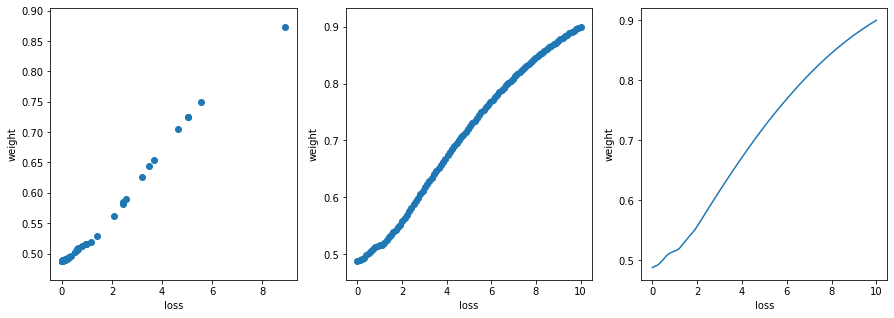

In [86]:
df = get_vnet_scatter_df(model, vnet, get_vnet_map_func=get_vnet_map)

### VNet_v2 loss-weight scatter/curve on meta data

v2 acc: 0.81


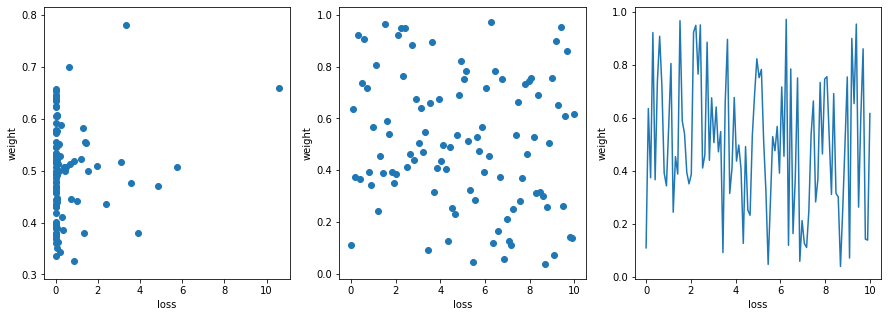

In [87]:
df_v2 = get_vnet_scatter_df(model_v2, vnet_v2, 'v2', get_vnet_v2_map)

### VNet_v1 loss-weight scatter on meta data

v1 acc: 0.85


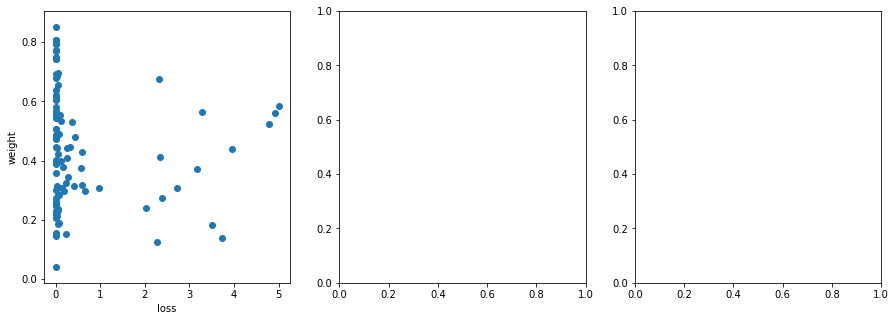

In [88]:
df_v1 = get_vnet_scatter_df(model_v1, vnet_v1, version='v1')

### Directly see the loss-weight of VNet, v1, v2

In [62]:
df.sort_values(by=['loss'])

,logits,pred,gt,loss,weight
82,"[-2.64, 13.49, -1.77, 1.03, -2.54, -1.0, -1.14, -2.63, -2.92, 0.12]",1,1,0.00000,0.39258
27,"[12.56, 0.2, 0.03, -2.4, 0.0, -4.66, -0.47, -2.05, -0.89, -2.34]",0,0,-0.00000,0.47774
75,"[0.76, -2.74, 13.78, -0.85, 0.23, -0.46, -0.09, -1.62, -4.24, -4.78]",2,2,-0.00000,0.57800
34,"[6.77, 2.87, -6.03, 1.64, -6.99, -6.11, -6.39, -2.4, 1.13, 15.5]",9,9,-0.00000,0.52651
11,"[3.57, 6.86, -7.24, -0.29, -7.23, -7.28, -7.44, -1.66, 0.94, 19.77]",9,9,-0.00000,0.55495
67,"[3.58, -0.27, 15.29, -2.2, -3.23, -3.7, -0.61, -1.96, -3.41, -3.51]",2,2,0.00001,0.64554
51,"[2.25, 0.93, -1.42, -1.5, -2.54, -4.12, 3.69, -3.41, 7.2, -1.11]",8,8,0.00001,0.37902
1,"[5.55, 8.4, -6.44, -2.67, -5.19, -6.78, -3.65, -4.66, 14.26, 1.16]",8,8,0.00001,0.63866
92,"[2.97, 0.54, -0.4, -1.02, -3.5, -3.77, -4.77, -1.42, 10.71, 0.65]",8,8,0.00002,0.46579
9,"[0.85, 12.58, -4.83, -0.09, -4.23, -2.83, -1.38, -2.29, 0.08, 2.15]",1,1,0.00002,0.39465


In [102]:
dff = df[df['pred'] != df['gt']]
sorted_dff = dff.sort_values(by=['loss'])
sorted_dff

,logits,pred,gt,loss,weight
2,"[4.12, 7.46, -2.42, -2.25,...",1,8,1.15693,0.51830
96,"[1.8, -0.96, 1.84, 0.62, 5...",4,6,1.41120,0.52958
52,"[2.16, -2.07, 2.76, 3.57, ...",3,0,2.08673,0.56193
61,"[-2.96, -2.89, 2.2, 4.83, ...",5,3,2.42795,0.58217
58,"[1.02, -2.14, -2.06, 4.32,...",3,4,2.45872,0.58403
59,"[-1.09, -1.21, -0.16, 4.2,...",3,6,2.56151,0.59010
17,"[1.07, 0.52, -1.45, 4.92, ...",3,7,3.18303,0.62620
22,"[7.2, -3.41, 2.13, 0.9, 3....",0,4,3.49429,0.64378
76,"[7.94, 2.43, -0.09, -0.92,...",0,9,3.68650,0.65446
62,"[1.16, -0.64, -0.18, 5.34,...",3,6,4.62881,0.70442


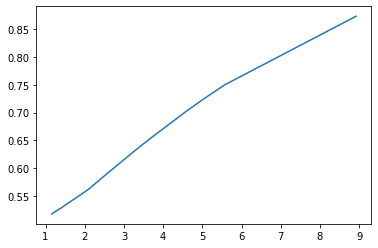

In [103]:
plt.plot(sorted_dff['loss'], sorted_dff['weight'])

In [109]:
pd.options.display.max_colwidth = 100
df_v1.sort_values(by=['weight'])

,logits,pred,gt,loss,weight
90,"[13.22, 2.48, -1.21, -3.34, 3.33, -6.44, -4.54, -2.06, 0.47, -1.92]",0,0,0.00008,0.03915
22,"[6.85, -3.69, 1.65, 0.04, 4.71, -2.67, -0.81, -3.43, 1.09, -3.74]",0,4,2.26139,0.12490
40,"[7.0, -1.3, 4.69, 0.02, 3.39, -3.61, -1.46, -2.8, -1.86, -4.07]",0,4,3.73245,0.13794
44,"[10.61, 1.55, 0.47, -2.53, -1.5, -5.04, -4.89, 0.88, -0.12, 0.58]",0,0,0.00029,0.14619
10,"[10.18, -2.42, 0.44, 0.48, 0.62, -1.09, -4.1, -0.52, -0.89, -2.7]",0,0,0.00025,0.15072
54,"[7.86, 1.0, 0.13, -2.46, -2.03, -6.68, -3.27, -3.61, 9.17, -0.1]",8,8,0.23948,0.15112
94,"[-1.52, -3.58, 1.42, 2.16, 9.68, 1.76, -0.59, -0.06, -3.77, -5.51]",4,4,0.00128,0.15631
47,"[5.97, 1.07, -0.41, -1.51, 0.41, -4.58, -3.32, -1.16, 1.0, 2.52]",0,9,3.49885,0.18281
26,"[-2.85, -3.76, 4.91, 4.68, 8.34, 0.63, 0.18, -1.86, -4.43, -5.86]",4,4,0.05741,0.18691
73,"[6.43, 3.36, -2.37, -3.46, -0.86, -5.97, -1.75, -3.84, 9.16, -0.68]",8,8,0.06614,0.18998


In [111]:
print(np.sum(df['loss'] * df['weight']))
print(np.sum(df_v1['loss'] * df_v1['weight']))
print(np.sum(df_v2['loss'] * df_v2['weight']))

21.846337326070255


In [104]:
dffv1 = df_v1[df_v1['pred'] != df_v1['gt']]
sorted_dffv1 = dffv1.sort_values(by=['loss'])
sorted_dffv1

,logits,pred,gt,loss,weight
12,"[-3.85, -3.7, -0.76, 4.05,...",4,5,0.96934,0.30724
32,"[0.07, -2.13, 5.68, 0.39, ...",2,4,2.03418,0.24102
22,"[6.85, -3.69, 1.65, 0.04, ...",0,4,2.26139,0.12490
35,"[-3.66, 2.39, 2.08, 3.92, ...",3,2,2.31682,0.67421
59,"[-0.57, -2.47, 0.82, 5.38,...",3,6,2.32927,0.41176
25,"[-0.04, -3.64, 3.13, 4.98,...",3,2,2.38954,0.27372
24,"[-2.56, -3.22, 0.62, 3.83,...",4,5,2.72546,0.30631
17,"[-1.9, -3.14, 0.66, 4.13, ...",4,7,3.17990,0.37016
52,"[1.02, -0.8, -0.14, 3.09, ...",5,0,3.28527,0.56346
47,"[5.97, 1.07, -0.41, -1.51,...",0,9,3.49885,0.18281


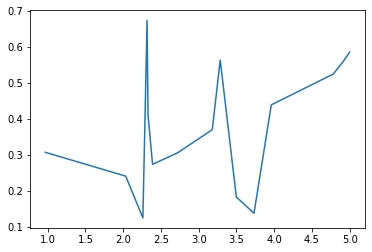

In [105]:
plt.plot(sorted_dffv1['loss'], sorted_dffv1['weight'])

In [106]:
dffv2 = df_v2[df_v2['pred'] != df_v2['gt']]
sorted_dffv2 = dffv2.sort_values(by=['loss'])
sorted_dffv2

,logits,pred,gt,loss,weight
70,"[6.09, -1.27, 5.99, 0.05, ...",0,2,0.74896,0.44453
69,"[0.4, -2.97, -0.25, -1.04,...",4,7,0.85159,0.32640
17,"[0.02, -1.74, -1.88, 3.54,...",3,7,0.89783,0.51897
56,"[-2.66, -4.13, 0.34, 2.96,...",5,7,0.99655,0.44178
87,"[3.81, -1.79, -0.27, 2.1, ...",0,7,1.21360,0.52261
95,"[-3.81, -2.51, 0.3, 5.97, ...",3,6,1.28841,0.58301
40,"[2.38, -0.18, 4.12, 3.17, ...",2,4,1.35751,0.37908
20,"[-0.13, 2.45, -3.95, -0.41...",4,7,1.40267,0.55564
47,"[4.69, 1.57, -1.37, 1.1, -...",0,9,1.42542,0.55235
23,"[2.83, 11.46, -4.23, -0.52...",1,9,1.51803,0.49943


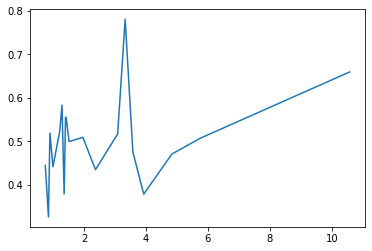

In [107]:
plt.plot(sorted_dffv2['loss'], sorted_dffv2['weight'])

### See the False-Predicted samples of VNet, v1, v2

In [80]:
def get_diff_idxs(df):
    diff = df['pred'] != df['gt']
    diff_idxs = [i for i in range(len(df['gt'])) if diff[i]]
    return diff_idxs

def better_print(l):
    print(len(l), sorted(l))

In [81]:
diff_idxs = set(get_diff_idxs(df))
diff_idxs_v1 = set(get_diff_idxs(df_v1))
diff_idxs_v2 = set(get_diff_idxs(df_v2))

better_print(diff_idxs)
better_print(diff_idxs_v1)
better_print(diff_idxs_v2)

14 [2, 17, 22, 24, 40, 52, 57, 58, 59, 61, 62, 76, 87, 96]
15 [12, 17, 22, 24, 25, 32, 35, 40, 47, 52, 57, 58, 59, 61, 62]
19 [2, 17, 20, 23, 24, 40, 47, 52, 56, 57, 58, 59, 61, 62, 69, 70, 86, 87, 95]


In [84]:
better_print(diff_idxs & diff_idxs_v1)
better_print(diff_idxs & diff_idxs_v2)
better_print(diff_idxs & diff_idxs_v1 & diff_idxs_v2)

10 [17, 22, 24, 40, 52, 57, 58, 59, 61, 62]
11 [2, 17, 24, 40, 52, 57, 58, 59, 61, 62, 87]
9 [17, 24, 40, 52, 57, 58, 59, 61, 62]


- v1 和 VNet 效果更接近
- 三种 Vnet 同时估计错误的样本很多